<a href="https://colab.research.google.com/github/erdeq-upenn/sample_proj/blob/master/TakeHome_predict_biz_loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem background
Forecasting customer behavior in the next 3/6/9/12 months are
key for our risk controls. It is crucial to have a good understanding of and solid foundations in data generation/gathering, feature engineering, machine learning modeling, and model evaluations.

To replicate the similar forecasting problem without exposing confidential data, we’ll be
utilizing Google Trends data, which shows search interests over time. We’d like you to
make 3-month, 6-month, 9-month, and 12-month predictions of “Business Loan” interest
scores in this exercise.

With the insights and features you gathered from previous sections, develop a data
science model that makes 3-month, 6-month, 9-month, and 12-month predictions of
“Business Loan” interest scores.


# Build the fundation of time series prediction


## General Imports

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from prophet.plot import plot_plotly, plot_components_plotly

!pip install google-search-results
!pip install prophet
# install SerpApi from https://serpapi.com/google-trends-api,
# that can mimic the google trends api

from serpapi import GoogleSearch
from prophet import Prophet
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Selection of API
Since Google doesn't provide API for google trends, the only way to access data is through 3rd party. SerpApi is one of the choices that allow you to scrape results from the Google Trends search page.

[SerpApi](https://serpapi.com/google-trends-api)

In [17]:
params = {
  "engine": "google_trends",
  "location": "United States",
  "q": "business loan",
  "data_type": "TIMESERIES",
  "date":"2019-01-01 2024-02-20",
  "api_key": "8f7947405f09306715bb719de8d54ff3322c6164127c40759fd9d384dbde49ce"
}

def query_api(key,params=params):
  params["q"]=key
  print(params)
  search = GoogleSearch(params)
  results = search.get_dict()
  interest_over_time = results["interest_over_time"]
  res = []
  for i in interest_over_time['timeline_data']:
    res.append((i['timestamp'],float(i['values'][0]['value'])))
  df = pd.DataFrame(res,columns=['date',key.replace(' ','_')])
  df.date = pd.to_datetime(df.date,unit='s')
  return df

keys = ['business loan','personal loan','student loan']
dfs = []
for key in keys:
  dfs.append(query_api(key))

import functools as ft
df = ft.reduce(lambda left, right: pd.merge(left, right, on='date'), dfs)

{'engine': 'google_trends', 'location': 'United States', 'q': 'business loan', 'data_type': 'TIMESERIES', 'date': '2019-01-01 2024-02-20', 'api_key': '8f7947405f09306715bb719de8d54ff3322c6164127c40759fd9d384dbde49ce'}
{'engine': 'google_trends', 'location': 'United States', 'q': 'personal loan', 'data_type': 'TIMESERIES', 'date': '2019-01-01 2024-02-20', 'api_key': '8f7947405f09306715bb719de8d54ff3322c6164127c40759fd9d384dbde49ce', 'output': 'json', 'source': 'python'}
{'engine': 'google_trends', 'location': 'United States', 'q': 'student loan', 'data_type': 'TIMESERIES', 'date': '2019-01-01 2024-02-20', 'api_key': '8f7947405f09306715bb719de8d54ff3322c6164127c40759fd9d384dbde49ce', 'output': 'json', 'source': 'python'}


<Axes: xlabel='date'>

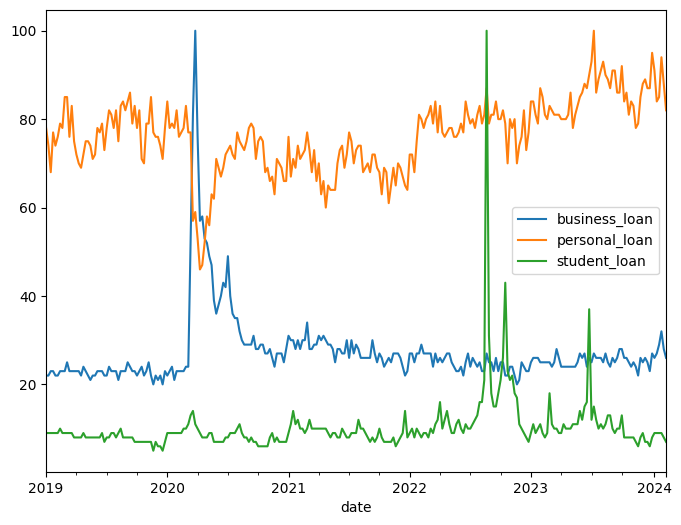

In [18]:
# plot the trends of query
df.head(),df.shape
df.plot.line(x='date')

## Univariant analysis
Since the google trend data is normalized to the maximum, which will be misleading doing prediction comparison, we rescale the data to the most recent week with level of 100.

There are many ways to deal with time series data. One can use simple linear regression, to more complicated RNN or LSTM neural networks. There is powerful a tool for TS data analysis. We can use it as a start point.

<img src="https://facebook.github.io/prophet/static/logo.svg" alt="ER diagram" width="200"/>

[Prophet](https://facebook.github.io/prophet/)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuft4x1g/uk7xeomh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuft4x1g/vfkayag3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28615', 'data', 'file=/tmp/tmpzuft4x1g/uk7xeomh.json', 'init=/tmp/tmpzuft4x1g/vfkayag3.json', 'output', 'file=/tmp/tmpzuft4x1g/prophet_modelj_gw8_5o/prophet_model-20240221173830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


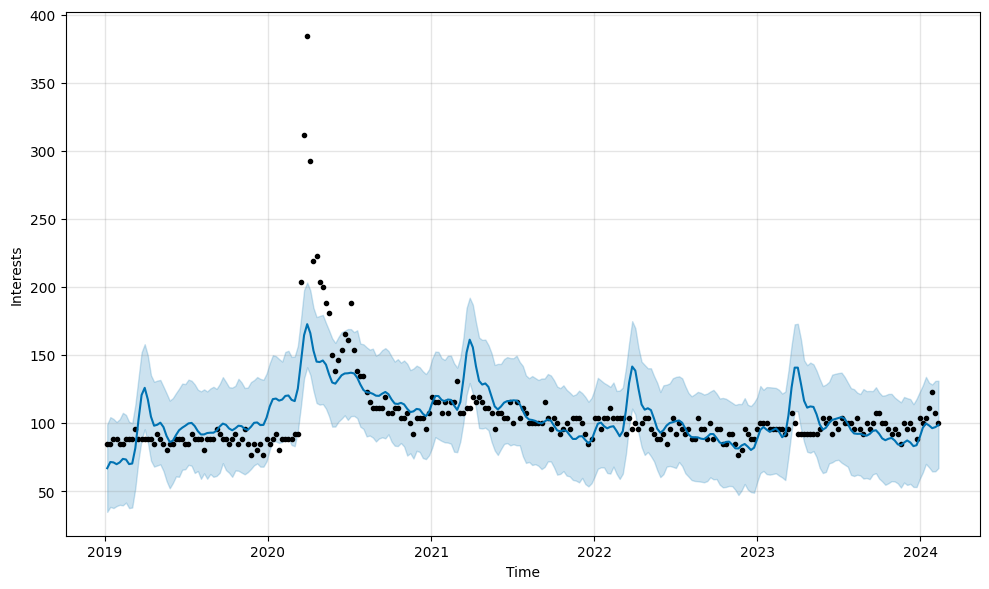

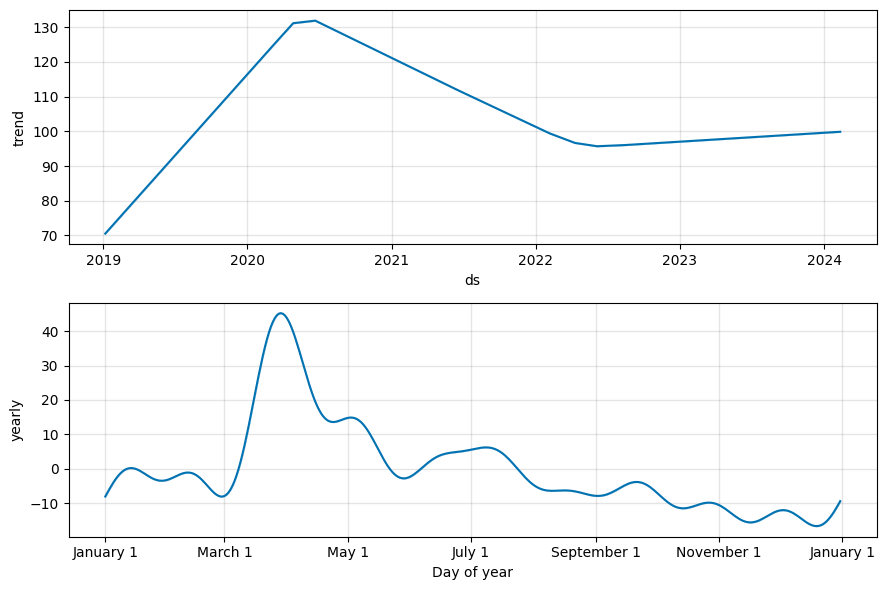

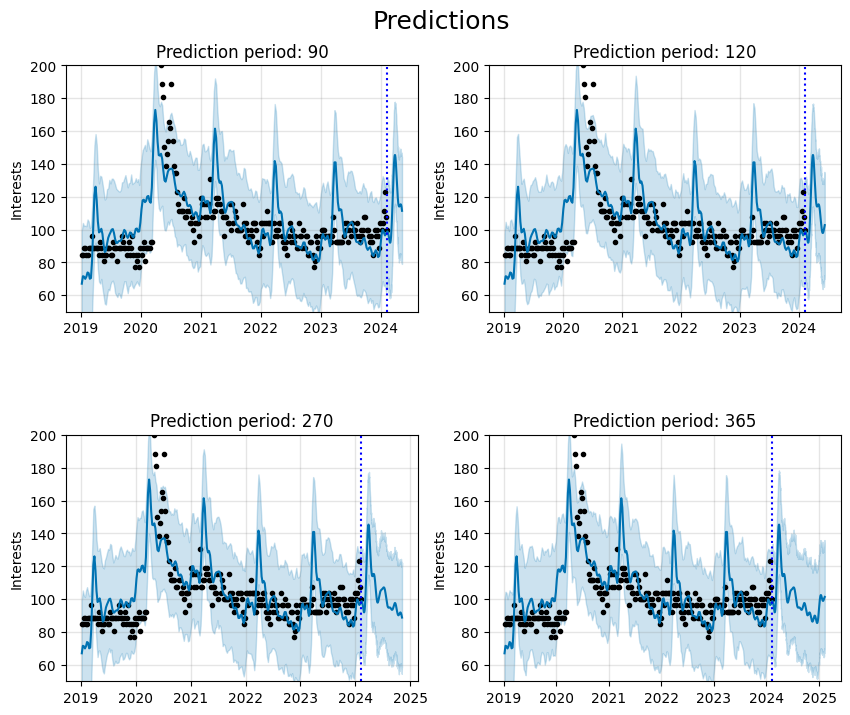

In [79]:
def make_prdiction(df, model, ax, period=30, verbatim =False):
  # use Prophet TS model
  # import fittd model
  m = model
  future = m.make_future_dataframe(periods=period)
  if verbatim: print(future.tail)
  forecast = m.predict(future)
  if verbatim: print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

  # interactive plot
  # fig = plot_plotly(m, forecast)
  fig1 = m.plot(forecast,ax=ax)
  ax.set_xlabel('Time')
  ax.set_ylabel('Interests')
  # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

  return fig1

# df2 = pd.concat([df.date, df.drop(columns = 'date')/df.iloc[-1,-1]*100],axis=1)
df2 = pd.concat([df.date,df.business_loan/df.iloc[-1,:]['business_loan']*100],axis=1)
# prepare for Prophet
df2.columns = ['ds','y']
df2.ds = pd.to_datetime(df2.ds)
m = Prophet()
m.fit(df2)
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)
m.plot(forecast)
plt.xlabel('Time')
plt.ylabel('Interests')

# components
fig2 = m.plot_components(forecast)

# pred = make_prdiction(df,period=90)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Predictions", fontsize=18, y=0.95)
tickers = [90,120,270,365]
# preview of data

for ticker, ax in zip(tickers, axs.ravel()):
    # filter df for ticker and plot on specified axes
    make_prdiction(df2,model=m,ax=ax,period=ticker,verbatim =False)

    # chart formatting
    ax.set_title('Prediction period: %s'%ticker)
    # ax.get_legend().remove()
    ax.set_xlabel("")
    ax.axvline(x = df.iloc[-1,0], color = 'b',ls=':', label = 'axvline - full height')
    ax.set_ylim([50,200])


### shock analysis
From above plots, one may predict that there is going to have a peak in beginning of 2024 and then die down. However, if we look closely to the data, it may not be true.  Since data include COVID-19 period, which is a shock to time series. It is important to reduce the shock effect. Treating COVID-19 lockdowns as a one-off holidays. To prevent large dips and spikes from being captured by the trend component, we can treat the days impacted by COVID-19 as holidays that will not repeat again in the future. Adding custom holidays is explained in more detail here. We set up a DataFrame like so to describe the periods affected by lockdowns:

In [80]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuft4x1g/ynxn7dfa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuft4x1g/oh2j0vwa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11381', 'data', 'file=/tmp/tmpzuft4x1g/ynxn7dfa.json', 'init=/tmp/tmpzuft4x1g/oh2j0vwa.json', 'output', 'file=/tmp/tmpzuft4x1g/prophet_modelkpm0d7rm/prophet_model-20240221173758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


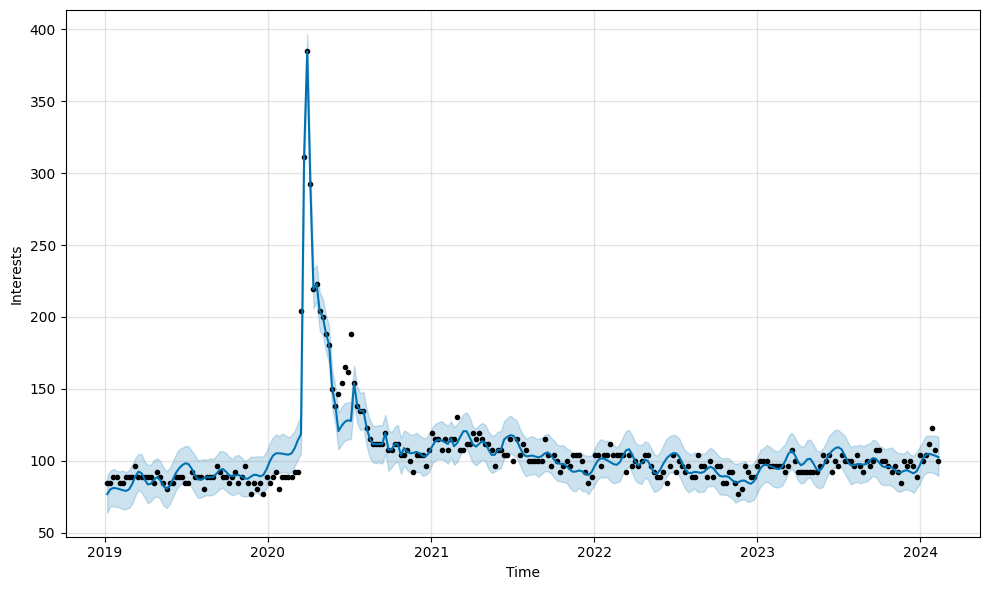

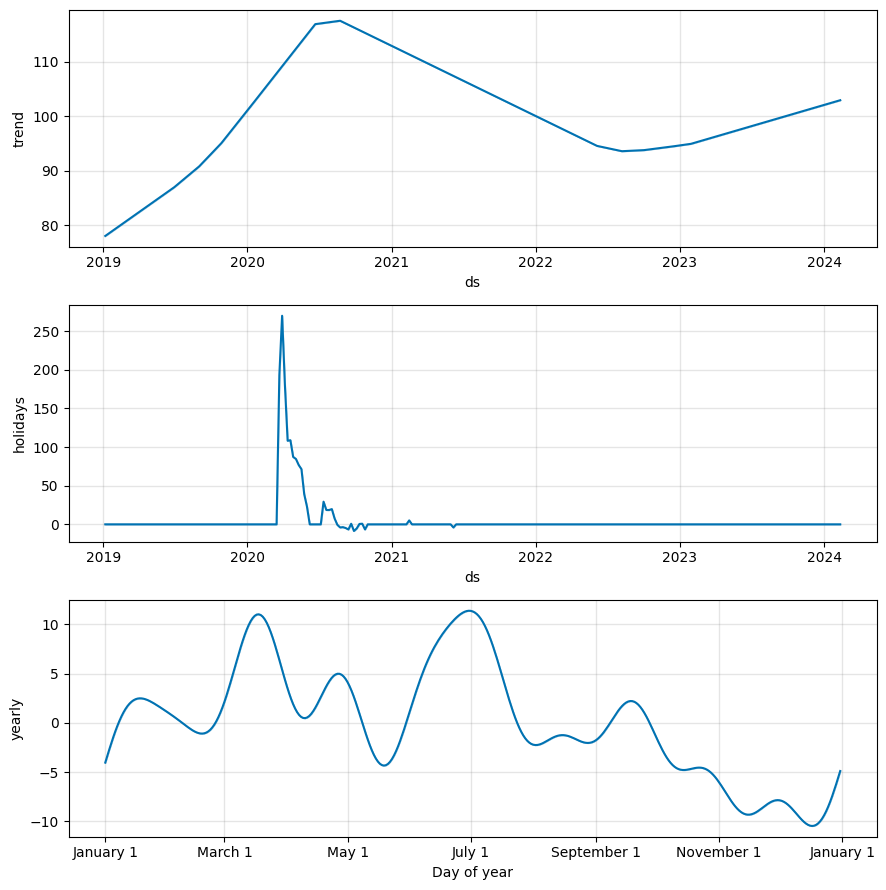

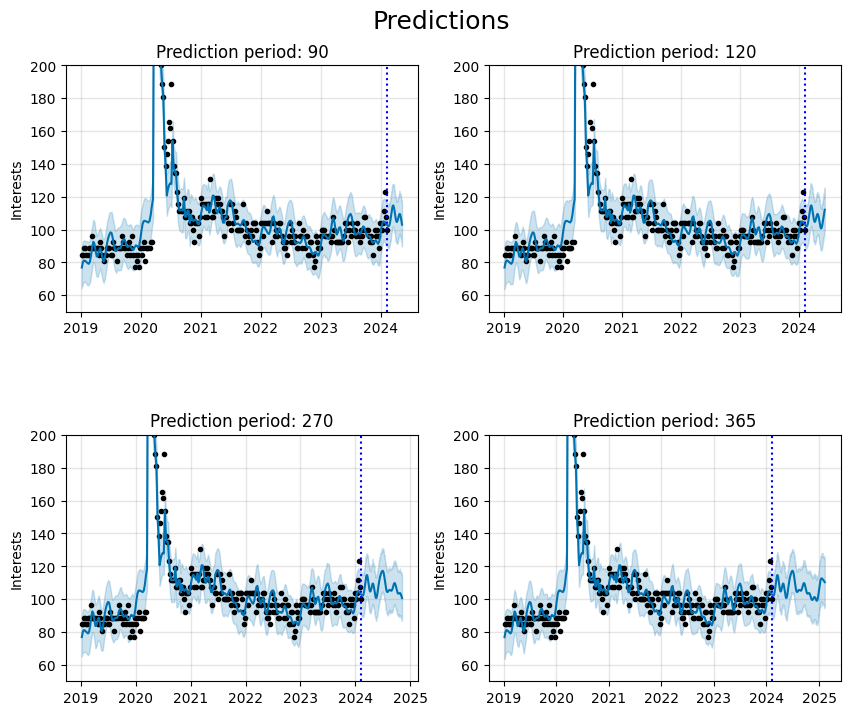

In [78]:
m2 = Prophet(holidays=lockdowns)
m2.fit(df2)
future = m2.make_future_dataframe(periods=0)
forecast = m2.predict(future)
m2.plot(forecast)
plt.xlabel('Time')
plt.ylabel('Interests')

# components
fig2 = m2.plot_components(forecast)

# pred = make_prdiction(df,period=90)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Predictions", fontsize=18, y=0.95)
tickers = [90,120,270,365]
# preview of data

for ticker, ax in zip(tickers, axs.ravel()):
    # filter df for ticker and plot on specified axes
    make_prdiction(df2,model=m2,ax=ax,period=ticker,verbatim =False)

    # chart formatting
    ax.set_title('Prediction period: %s'%ticker)
    # ax.get_legend().remove()
    ax.set_xlabel("")
    ax.axvline(x = df.iloc[-1,0], color = 'b',ls=':', label = 'axvline - full height')
    ax.set_ylim([50,200])

After corrections of the COVID shock, we have a smoother prediction of the future trends. They are less jumpy with overall increasing trend.

## Multi-variant analysis

In [20]:
df2 = pd.concat([df.date, df.drop(columns = 'date')/df.iloc[-1,:]['business_loan']*100],axis=1)
date_time = df2.pop('date')
date_time = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
week = day*7
year = (365.2425)*day
df2['Day_sin'] = np.sin(date_time * (2 * np.pi / day))
# df2['Day_cos'] = np.cos(date_time * (2 * np.pi / day))

df2['Week_sin'] = np.sin(date_time * (2 * np.pi / week))
df2['Week_cos'] = np.cos(date_time * (2 * np.pi / week))

df2['Year_sin'] = np.sin(date_time * (2 * np.pi / year))
df2['Year_cos'] = np.cos(date_time * (2 * np.pi / year))

In [21]:
column_indices = {name: i for i, name in enumerate(df2.columns)}

n = len(df2)
train_df = df2[0:int(n*0.7)]
val_df = df2[int(n*0.7):int(n*0.9)]
test_df = df2[int(n*0.9):]

num_features = df2.shape[1]
value = 'business_loan'

In [22]:
n, train_df.shape, val_df.shape,test_df.shape

(267, (186, 8), (54, 8), (27, 8))

In [23]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<ipython-input-24-e49d7761bed9>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df2.keys(), rotation=90)


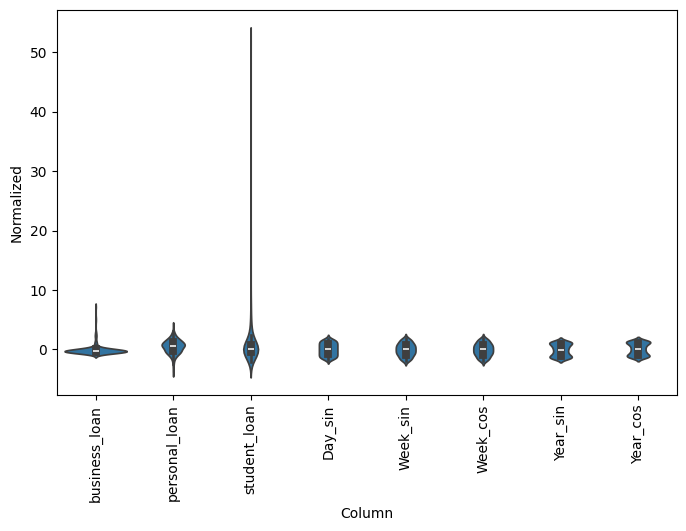

In [24]:
df_std = (df2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(8, 5))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df2.keys(), rotation=90)

In [25]:
## windowing
# 1. Indexes and offsets
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col=value, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(8, 6))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [wk]')

WindowGenerator.plot = plot

def pred_plot(self, model=None, plot_col=value, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(8, 2))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))

  # plt.subplot(max_n, 1, n+1)
  n = -1
  plt.ylabel(f'{plot_col} [normed]')
  plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

  if self.label_columns:
    label_col_index = self.label_columns_indices.get(plot_col, None)
  else:
    label_col_index = plot_col_index

  if label_col_index is None:
    pass

  plt.scatter(self.label_indices, labels[n, :, label_col_index],
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
  if model is not None:
    predictions = model(inputs)
    plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)


    plt.legend()

  plt.xlabel('Time [wk]')

WindowGenerator.pred_plot = pred_plot

In [26]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[value])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['business_loan']

In [27]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[10:10+w2.total_window_size]),
                           np.array(train_df[2:2+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 8)
Inputs shape: (3, 6, 8)
Labels shape: (3, 1, 1)


In [28]:
w2.example = example_inputs, example_labels

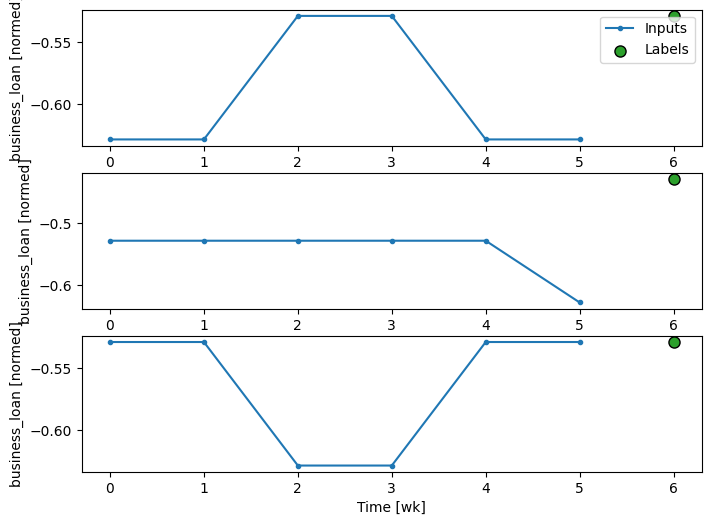

In [29]:
w2.plot()

### Making the dataset

In [30]:
## making dataset
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Single Step modeling

In [31]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[value])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['business_loan']

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 8)
Labels shape (batch, time, features): (32, 1, 1)


In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]
baseline = Baseline(label_index=column_indices[value])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2/2 [==============================] - 1s 14ms/step - loss: 0.0266 - mean_absolute_error: 0.1166


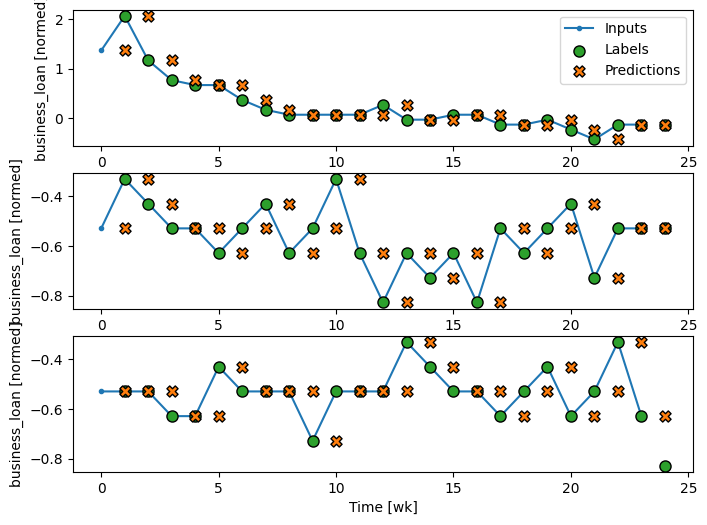

In [34]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[value])

wide_window
wide_window.plot(baseline)

####  Linear Model explanation

In [35]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 8)
Output shape: (32, 1, 1)


In [36]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/200
6/6 [==============================] - 2s 82ms/step - loss: 1.2654 - mean_absolute_error: 0.8875 - val_loss: 20.0264 - val_mean_absolute_error: 2.4682
Epoch 2/200
6/6 [==============================] - 0s 31ms/step - loss: 1.2351 - mean_absolute_error: 0.8763 - val_loss: 19.7618 - val_mean_absolute_error: 2.4483
Epoch 3/200
6/6 [==============================] - 0s 24ms/step - loss: 1.2048 - mean_absolute_error: 0.8652 - val_loss: 19.5705 - val_mean_absolute_error: 2.4319
Epoch 4/200
6/6 [==============================] - 0s 24ms/step - loss: 1.1759 - mean_absolute_error: 0.8544 - val_loss: 19.3229 - val_mean_absolute_error: 2.4126
Epoch 5/200
6/6 [==============================] - 0s 24ms/step - loss: 1.1489 - mean_absolute_error: 0.8438 - val_loss: 19.0943 - val_mean_absolute_error: 2.3941
Epoch 6/200
6/6 [==============================] - 0s 21ms/step - loss: 1.1205 - mean_absolute_error: 0.8328 - val_loss: 18.8313 - val_mean_absolute_error: 2.3740
Epoch 7/200
6/6 [=====

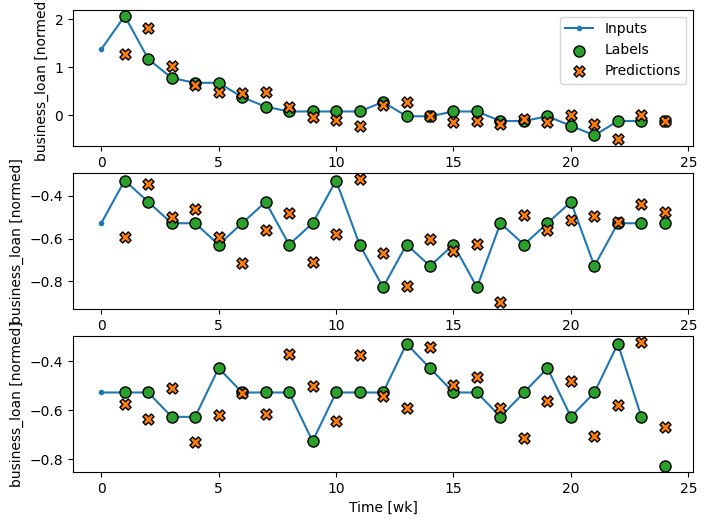

In [37]:
wide_window.plot(linear)

,Feature_Impact
student_loan,0.092640
Week_sin,0.068345
Year_cos,0.023397
Week_cos,0.006190
Year_sin,-0.008060
personal_loan,-0.034130
Day_sin,-0.042390


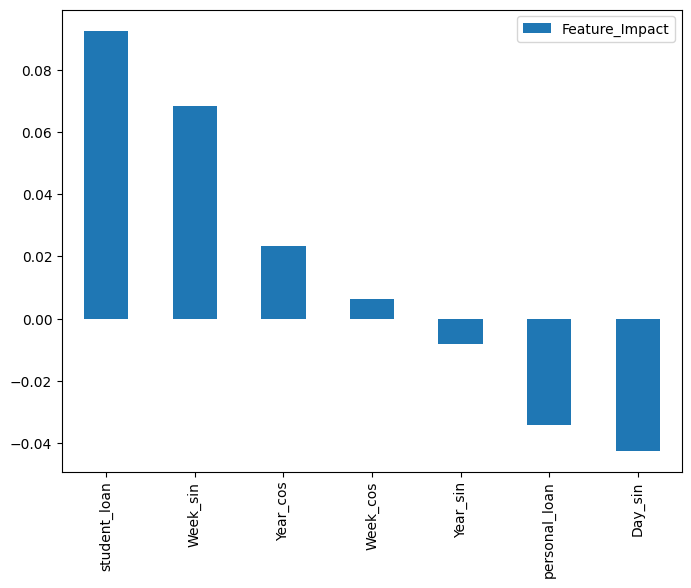

In [38]:
fi = pd.DataFrame(linear.layers[0].kernel[:,0].numpy(),index=train_df.columns,columns=['Feature_Impact'])
fi = fi.sort_values('Feature_Impact',ascending =False)
fi = fi.loc[fi.index.drop('business_loan')]
fi.plot.bar()
fi

### multistep modeling
Showcase of the multistep model prediction.

Total window size: 16
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11 12 13 14 15]
Label column name(s): None

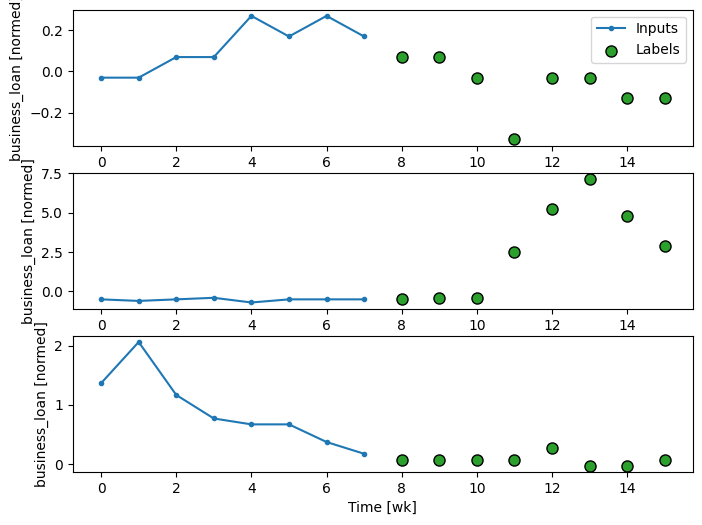

In [99]:
OUT_STEPS = 8
multi_window = WindowGenerator(input_width=8,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

2/2 [==============================] - 0s 8ms/step - loss: 3.6329 - mean_absolute_error: 1.0532


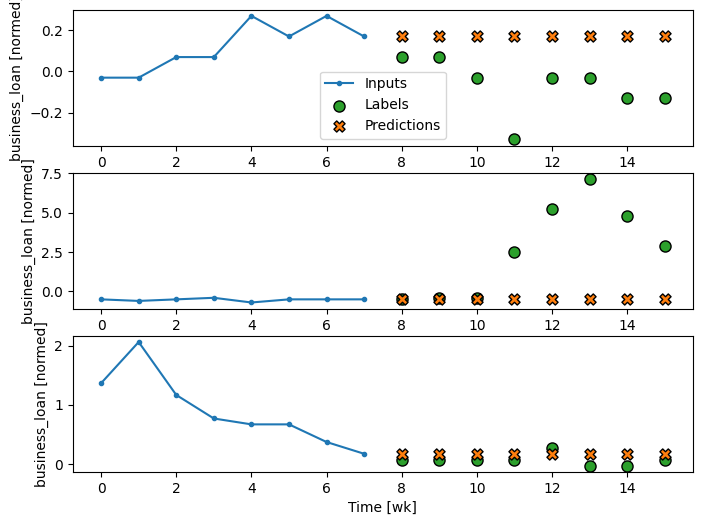

In [100]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

2/2 [==============================] - 0s 7ms/step - loss: 6.6489 - mean_absolute_error: 1.4627


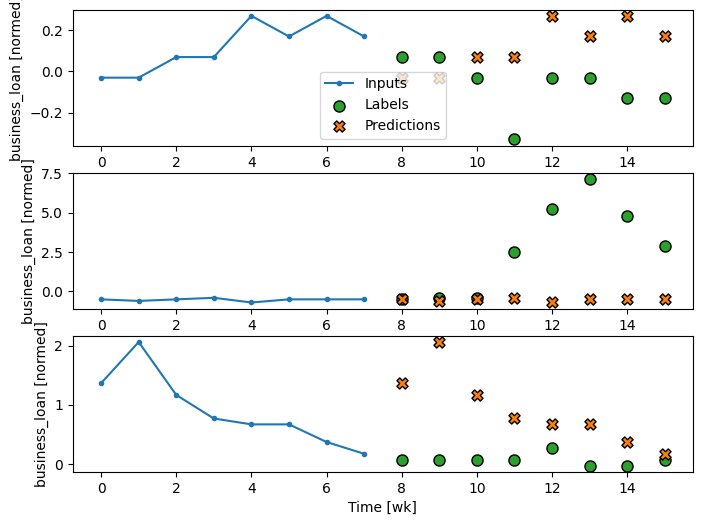

In [101]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [102]:
## linear model
MAX_EPOCHS = 500

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

2/2 [==============================] - 0s 7ms/step - loss: 2.5267 - mean_absolute_error: 0.8263


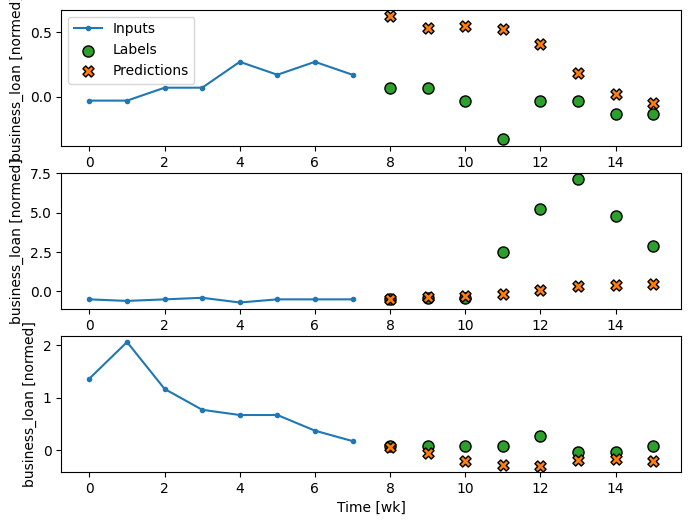

In [103]:
# Linear
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

2/2 [==============================] - 0s 6ms/step - loss: 2.4415 - mean_absolute_error: 0.7393


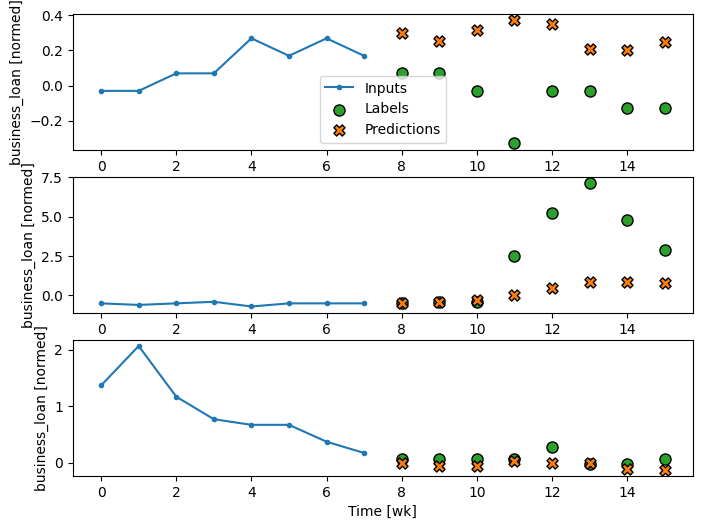

In [104]:
# Dense
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

2/2 [==============================] - 0s 10ms/step - loss: 2.4399 - mean_absolute_error: 0.7637


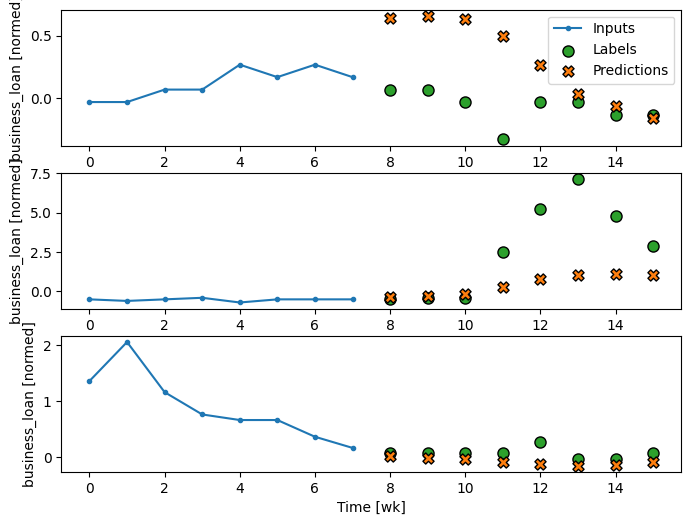

In [105]:
# CNN
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

2/2 [==============================] - 0s 8ms/step - loss: 2.9653 - mean_absolute_error: 0.9417


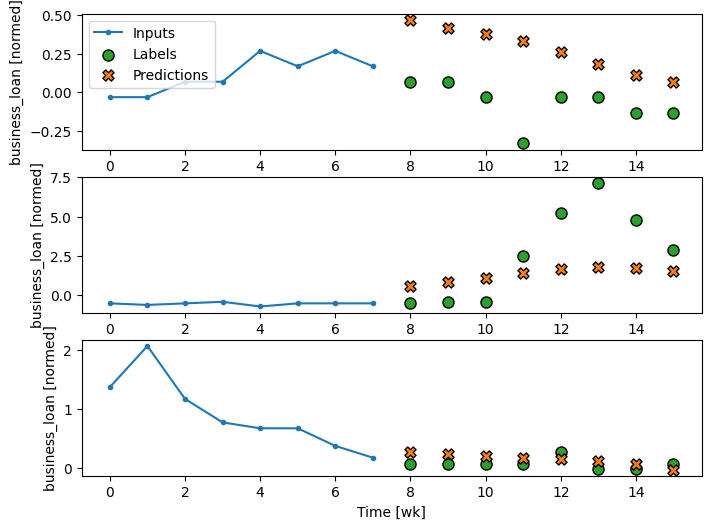

In [106]:
# RNN
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [107]:
# RNN
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
print(prediction.shape)


(32, 8)


2/2 [==============================] - 0s 8ms/step - loss: 3.1537 - mean_absolute_error: 1.1173


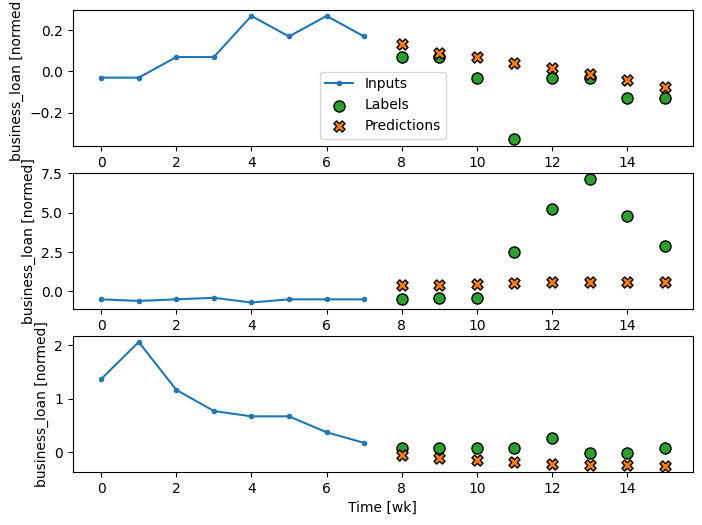

In [108]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

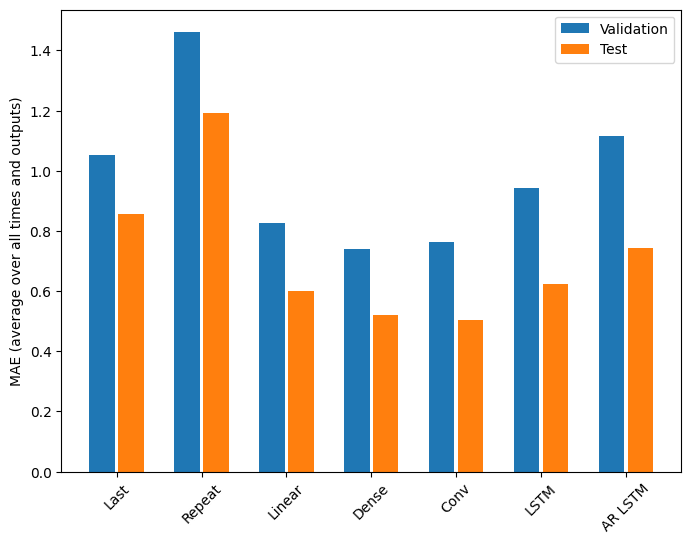

In [109]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [110]:
for name, value in sorted(multi_performance.items(),key = lambda x:x[1]):
  print(f'{name:8s}: {value[1]:0.4f}')

Conv    : 0.5032
Dense   : 0.5204
LSTM    : 0.6233
Linear  : 0.6006
AR LSTM : 0.7438
Last    : 0.8572
Repeat  : 1.1913


## Conclusion
COVID has a strong impact on the historical trend. We need to accommodate our models to that shock. Using both univariate and multivariate analysis of the time series, we show an increasing smooth trend of business loans in the next 3/6/9/12 month rather than jumpy trends. Using linear models, we find that student loan and seasonality are the top two drivers of the increasing trend. Among various models, we find out using CNN model can reach the best performance, even though with limited data. The next steps will be collecting more refined data, performing statistical analysis using the ARIMA model, and making predictions by state. Business conclusion includes closely watching spikes of the trend, and watching for change in student loan policies.